Replacing `https://github.com` by `https://colab.research.google.com/github` as mentioned in [stackoverflow](https://stackoverflow.com/questions/62596466/how-can-i-run-notebooks-of-a-github-project-in-google-colab)

### Download data

In [1]:
# if run in Google colab
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!pwd
!cd data && unzip PennFudanPed.zip > load_data.log

!git clone https://github.com/s-reaungamornrat/video_processing.git


--2025-09-24 05:36:47--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  31.3MB/s    in 1.6s    

2025-09-24 05:36:49 (31.3 MB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]

/content
Cloning into 'video_processing'...
remote: Enumerating objects: 395, done.
remote: Counting objects: 100% (395/395), done.
remote: Compressing objects: 100% (248/248), done.
remote: Total 395 (delta 197), reused 318 (delta 125), pack-reused 0 (from 0)
Receiving objects: 100% (395/395), 29.24 MiB | 35.60 MiB/s, done.
Resolving deltas: 100% (197/197), done.


### Main code

In [2]:
%matplotlib inline

import os
import re
import sys
import yaml
import random

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

seed=0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

In [3]:
from video_processing.yolov7.parameter_parser import parser
from video_processing.yolov7.models.model import Model
from video_processing.yolov7.models.ema import ModelEMA
from video_processing.yolov7.loss.module import ComputeLoss
from video_processing.yolov7.train.utils import setup_optimizer, labels_to_class_weights, train_an_epoch
from video_processing.yolov7.dataset.penn_fandu_dataset import PennFudanDataset
from video_processing.yolov7.utils.general import one_cycle, check_image_size
from video_processing.yolov7.dataset.anchors import check_anchor_matching
from video_processing.yolov7.test.utils import validate

In [4]:
!nvidia-smi

Wed Sep 24 05:37:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
data_dirpath='data/PennFudanPed'
result_dirpath='results'

argument=f"""
--data-dirpath {data_dirpath} --output-dirpath {result_dirpath}
--worker 1 --device cuda --batch-size 2 --nominal-batch-size 2
--img 1280 1280 --cfg yolov7-w6-pennfandu.yaml
--weights ''  --name yolov7-w6 --hyp hyp.scratch.p6.yaml --correct-exif --print-freq 40
--epochs 100
"""
# --n-training-data 100 --n-val-data 20 --dev-mode
args=parser.parse_args(argument.split())

device=torch.device('cpu' if not torch.cuda.is_available() or args.device=='cpu' else 'cuda')
print(f'Computing on {device} using batch size of {args.batch_size}')

if not os.path.isdir(args.output_dirpath):os.makedirs(args.output_dirpath)
args.checkpoint_dirpath=os.path.join(args.output_dirpath, args.checkpoint_dirname)
if not os.path.isdir(args.checkpoint_dirpath): os.makedirs(args.checkpoint_dirpath)

Computing on cuda using batch size of 2


In [6]:
# hyperparameters
with open(args.hyp) as f: hyp=yaml.load(f, Loader=yaml.SafeLoader)
# number of classes
nc=2

In [7]:
# train/val data loader
# Here since the data are small we are going to overfit training
train_dataset=PennFudanDataset(root=args.data_dirpath, image_dirname=args.image_dirname, mask_dirname=args.mask_dirname, hyp=hyp,
                        img_size=args.img_size[0], augment=False,  indices=np.arange(160))
val_dataset=PennFudanDataset(root=args.data_dirpath, image_dirname=args.image_dirname, mask_dirname=args.mask_dirname, hyp=hyp,
                        img_size=args.img_size[0], augment=False,  indices=np.arange(160,170))

train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=args.batch_size, num_workers=1, pin_memory=True,
                                        collate_fn=PennFudanDataset.collate_fn)
val_loader=torch.utils.data.DataLoader(dataset=val_dataset, batch_size=args.batch_size, num_workers=1, pin_memory=True,
                                        collate_fn=PennFudanDataset.collate_fn)

print(f'There are {len(train_dataset)} training images and {len(val_dataset)} validation images ')

There are 160 training images and 10 validation images 


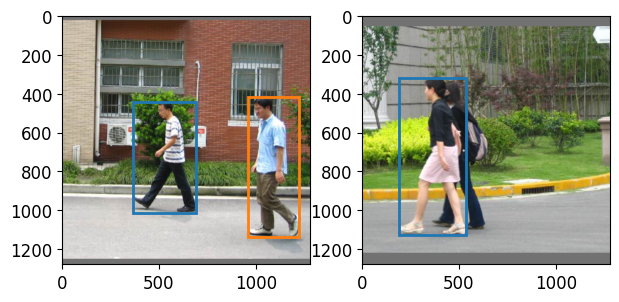

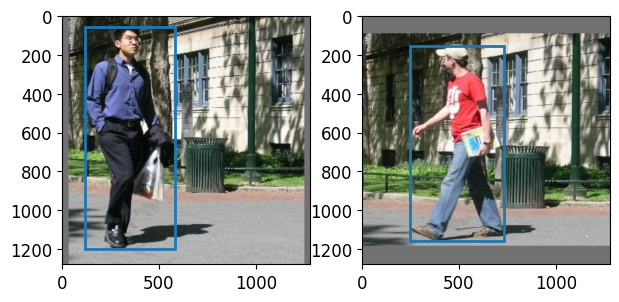

In [8]:
from matplotlib import patches
from video_processing.yolov7.dataset.coords import normalized_xywh2xyxy

cmap = plt.get_cmap('tab10', 10)
plt.rcParams.update({'font.size'   : 12})

imgs, labels, fpath,_=next(iter(train_loader))
_, ax=plt.subplots(1,imgs.shape[0],figsize=(6,3))
for i, img in enumerate(imgs):
    is_box=labels[:,0]==i # box of this image
    boxes=labels[:,2:][is_box]
    boxes=normalized_xywh2xyxy(boxes,w=img.shape[-1], h=img.shape[1])
    ax[i].imshow(img.permute(1,2,0)) # CxHxW to HxWxC
    for j, box in enumerate(boxes):
        # Create a Rectangle patch
        rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
        # Add the patch to the Axes
        ax[i].add_patch(rect)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

imgs, labels, fpath,_=next(iter(val_loader))
_, ax=plt.subplots(1,imgs.shape[0],figsize=(6,3))
for i, img in enumerate(imgs):
    is_box=labels[:,0]==i # box of this image
    boxes=labels[:,2:][is_box]
    boxes=normalized_xywh2xyxy(boxes,w=img.shape[-1], h=img.shape[1])
    ax[i].imshow(img.permute(1,2,0)) # CxHxW to HxWxC
    for j, box in enumerate(boxes):
        # Create a Rectangle patch
        rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
        # Add the patch to the Axes
        ax[i].add_patch(rect)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

In [9]:
# define model and optimizers
model=Model(args.cfg, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # it is safer to move model to device first and then create optimizer
optimizer=setup_optimizer(model, learning_rate=hyp['lr0'], momentum=hyp['momentum'], weight_decay=hyp['weight_decay'])
scheduler=torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=one_cycle(1., hyp['lrf'], args.epochs))
model_ema=ModelEMA(model)
start_epoch, best_fitness, best_loss=1, -np.inf, np.inf
if args.resume is not None and os.path.isfile(os.path.join(args.checkpoint_dirpath, args.resume)):
    resume_fpath=os.path.join(args.checkpoint_dirpath, args.resume)
    if os.path.isfile(os.path.join(args.checkpoint_dirpath, args.best_checkpoint_fname)):
        resume_fpath=os.path.join(args.checkpoint_dirpath, args.best_checkpoint_fname)
    checkpoint = torch.load(resume_fpath, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    start_epoch = checkpoint['epoch']+1
    if 'best_fitness' in checkpoint: best_fitness=checkpoint['best_fitness']
    if 'best_loss' in checkpoint: best_loss=checkpoint['best_loss']
    model_ema.ema.load_state_dict(checkpoint['ema'])
    model_ema.updates=checkpoint['updates']

# wrap distributed training

# check that the image size divisible by stride
max_stride=max(int(model.stride.max()), 32)
assert check_image_size(image_size=args.img_size, stride=max_stride), f'{args.img_size} must be divisible by {max_stride}'

In IAxDetect nl: 4 na: 3
In IAxDetect anchors: torch.Size([4, 3, 2]) 4x3x2
In IAxDetect anchor_grid: torch.Size([4, 1, 3, 1, 1, 2]) 4x1x3x1x1x2


In [10]:
# model parameters
nl=model.model[-1].nl
print("hyp['box'] ", hyp['box'],  " hyp['cls'] ", hyp['cls'], " hyp['obj] ", hyp['obj'] )
hyp['box']*=3./nl # box-regression loss weight scaled to layer
hyp['cls']*= nc/80. * 3./nl # classification loss weight scaled to classes and layers
hyp['obj']*=(args.img_size[0]/640)**2 *3./nl # objectness loss weight scaled to image size and layers
hyp['label_smoothing']=args.label_smoothing
model.nc=nc # attach number of classes to model
model.hyp=hyp
# blending factor between fixed objectness of 1 and IoU between prediction and ground truth
# used to set target objectness, i.e., target_objectness = (1-gr)+gr*iou
model.gr=1.
print("hyp['box'] ", hyp['box'],  " hyp['cls'] ", hyp['cls'], " hyp['obj] ", hyp['obj'], ' args.label_smoothing ', args.label_smoothing )
scheduler.last_epoch=start_epoch-1 # do not move?
train_loss_module=ComputeLoss(model, cls_pw=hyp['cls_pw'], obj_pw=hyp['obj_pw'], label_smoothing=args.label_smoothing, use_aux=True)
val_loss_module=ComputeLoss(model, cls_pw=hyp['cls_pw'], obj_pw=hyp['obj_pw'], label_smoothing=args.label_smoothing, use_aux=False)

hyp['box']  0.05  hyp['cls']  0.3  hyp['obj]  0.7
hyp['box']  0.037500000000000006  hyp['cls']  0.005625000000000001  hyp['obj]  2.0999999999999996  args.label_smoothing  0.0


In [ ]:
train_log = open(args.train_log, 'a')
train_log.write('t-w-loss, t-w-bb, t-w-obj, t-w-cls, t-bb, t-obj, t-cls, v-w-loss, v-w-bb, v-w-obj, v-w-cls, v-bb, v-obj, v-cls\n')
train_log.close()

for epoch in range(start_epoch, args.epochs):

    # train a model
    model.train()
    mean_weighted_loss, mean_unweigthed_loss=train_an_epoch(args, model, model_ema, optimizer, train_loss_module, train_loader, epoch=epoch)

    # scheduler
    scheduler.step()

    # mAP validation model
    model_ema.update_attr(model, include=['yaml', 'nc', 'hyp', 'gr', 'names', 'stride']) #, 'class_weights'])

    # validation: since it is small test, we use the model itself
    mean_val_weighted_loss,mean_val_unweighted_loss=validate(model=model, dataloader=val_loader, val_loss_module=val_loss_module, hyp=hyp,
                                      n_its=1 if args.dev_mode else None)

    val_txt=', '.join(f'{n}:{v.item():.3f}' for n, v in zip('bb,obj,cls'.split(','),mean_val_unweighted_loss))
    lr_txt=', '.join([f"{params['lr']:.3f}"  for params in optimizer.param_groups])
    print(f'Epoch {epoch}: train-loss={mean_weighted_loss[0].item():.3f}, val-loss={mean_val_weighted_loss[0].item():.3f}, {val_txt}, lr=({lr_txt})', flush=True)

    # save parameters
    training_state_dict={'epoch': epoch, 'model': model.state_dict(), 'ema':model_ema.ema.state_dict(),  'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(), 'updates':model_ema.updates, 'best_loss': best_loss}
    torch.save(training_state_dict, os.path.join(args.checkpoint_dirpath, args.resume))
    if mean_val_weighted_loss[0].item() < best_loss:
        best_loss=mean_val_weighted_loss[0].item()
        training_state_dict['best_loss']=best_loss
        torch.save(training_state_dict, os.path.join(args.checkpoint_dirpath, args.best_checkpoint_fname))

    # write log
    log=', '.join(f'{x.item()}' for x in mean_weighted_loss) + \
        ', '.join(f'{x.item()}' for x in mean_unweigthed_loss) + \
        ', '.join(f'{x.item()}' for x in mean_val_weighted_loss) + \
        ', '.join(f'{x.item()}' for x in mean_val_unweighted_loss)

    train_log = open(args.train_log, 'a')
    train_log.write(log+'\n')
    train_log.close()

In train.utils n_warmup 1000
40 [50.00%]: loss:0.057,  w-bb:0.048, w-obj:0.009, w-cls:0.000 | bb:1.274, obj:0.004, cls:0.080 | acc 1
80 [100.00%]: loss:0.054,  w-bb:0.043, w-obj:0.011, w-cls:0.000 | bb:1.153, obj:0.005, cls:0.053 | acc 1
Epoch 1: train-loss=0.054, val-loss=0.054, bb:1.260, obj:0.003, cls:0.014, lr=(0.001, 0.001, 0.001)
In train.utils n_warmup 1000
40 [50.00%]: loss:0.045,  w-bb:0.037, w-obj:0.008, w-cls:0.000 | bb:0.996, obj:0.004, cls:0.027 | acc 1
80 [100.00%]: loss:0.048,  w-bb:0.039, w-obj:0.009, w-cls:0.000 | bb:1.046, obj:0.004, cls:0.021 | acc 1
Epoch 2: train-loss=0.048, val-loss=0.055, bb:1.336, obj:0.002, cls:0.007, lr=(0.001, 0.001, 0.001)
In train.utils n_warmup 1000
40 [50.00%]: loss:0.044,  w-bb:0.036, w-obj:0.007, w-cls:0.000 | bb:0.962, obj:0.004, cls:0.015 | acc 1
80 [100.00%]: loss:0.043,  w-bb:0.034, w-obj:0.009, w-cls:0.000 | bb:0.905, obj:0.004, cls:0.011 | acc 1
Epoch 3: train-loss=0.043, val-loss=0.055, bb:1.316, obj:0.003, cls:0.006, lr=(0.001, 